In [15]:
# Module 1: Configuration and Imports

import os
import pandas as pd
import matplotlib.pyplot as plt

# Root directory where evaluation outputs are stored
base_dir = os.path.expanduser("~/Desktop/temp/Repeatability")

# Evaluation models to process
eval_models = [
    "eval_topk_gpt",
    "eval_topk_claude",
    "eval_topp_gpt",
    "eval_topp_claude"
]

# Versions 1 through 10
versions = list(range(1, 11))

# List of topic names
name_list = ["48", "518", "1081", "climate_change", "college_life",
             "fast_food", "food", "movie", "nba", "product"]

# Metrics to track
metric_cols = [
    "relevance_score", "correctness_score", "faithfulness_score", 
    "precision_score", "recall_score", "joint_score"
]

# Output directory for merged tables
output_dir = os.path.join(base_dir, "eval_model")
os.makedirs(output_dir, exist_ok=True)


In [17]:
# Module 2: Merge per model-version and add average row

for model in eval_models:
    for version in versions:
        merged_df = pd.DataFrame()
        missing_files = []

        for name in name_list:
            path = os.path.join(base_dir, model, str(version), name, f"{name}_post_joint_metric.csv")
            if os.path.exists(path):
                df = pd.read_csv(path)
                merged_df = pd.concat([merged_df, df], ignore_index=True)
            else:
                missing_files.append(name)

        if not merged_df.empty:
            # Add an average row at the bottom
            avg_row = merged_df[metric_cols].mean(numeric_only=True).round(3)
            avg_row_df = pd.DataFrame([avg_row])
            avg_row_df.insert(0, "respondent_id", "AVG")
            merged_df = pd.concat([merged_df, avg_row_df], ignore_index=True)

            # Save the merged DataFrame
            out_path = os.path.join(output_dir, f"{model}_{version}.csv")
            merged_df.to_csv(out_path, index=False)
            print(f"✅ Saved: {out_path}")

        else:
            print(f"⚠️ Skipped {model} version {version} (no data)")
            if missing_files:
                print(f"   Missing topics: {missing_files}")


✅ Saved: /Users/robbie/Desktop/temp/Repeatability/eval_model/eval_topk_gpt_1.csv
✅ Saved: /Users/robbie/Desktop/temp/Repeatability/eval_model/eval_topk_gpt_2.csv
✅ Saved: /Users/robbie/Desktop/temp/Repeatability/eval_model/eval_topk_gpt_3.csv
✅ Saved: /Users/robbie/Desktop/temp/Repeatability/eval_model/eval_topk_gpt_4.csv
✅ Saved: /Users/robbie/Desktop/temp/Repeatability/eval_model/eval_topk_gpt_5.csv
✅ Saved: /Users/robbie/Desktop/temp/Repeatability/eval_model/eval_topk_gpt_6.csv
✅ Saved: /Users/robbie/Desktop/temp/Repeatability/eval_model/eval_topk_gpt_7.csv
✅ Saved: /Users/robbie/Desktop/temp/Repeatability/eval_model/eval_topk_gpt_8.csv
✅ Saved: /Users/robbie/Desktop/temp/Repeatability/eval_model/eval_topk_gpt_9.csv
✅ Saved: /Users/robbie/Desktop/temp/Repeatability/eval_model/eval_topk_gpt_10.csv
✅ Saved: /Users/robbie/Desktop/temp/Repeatability/eval_model/eval_topk_claude_1.csv
✅ Saved: /Users/robbie/Desktop/temp/Repeatability/eval_model/eval_topk_claude_2.csv
✅ Saved: /Users/robbi

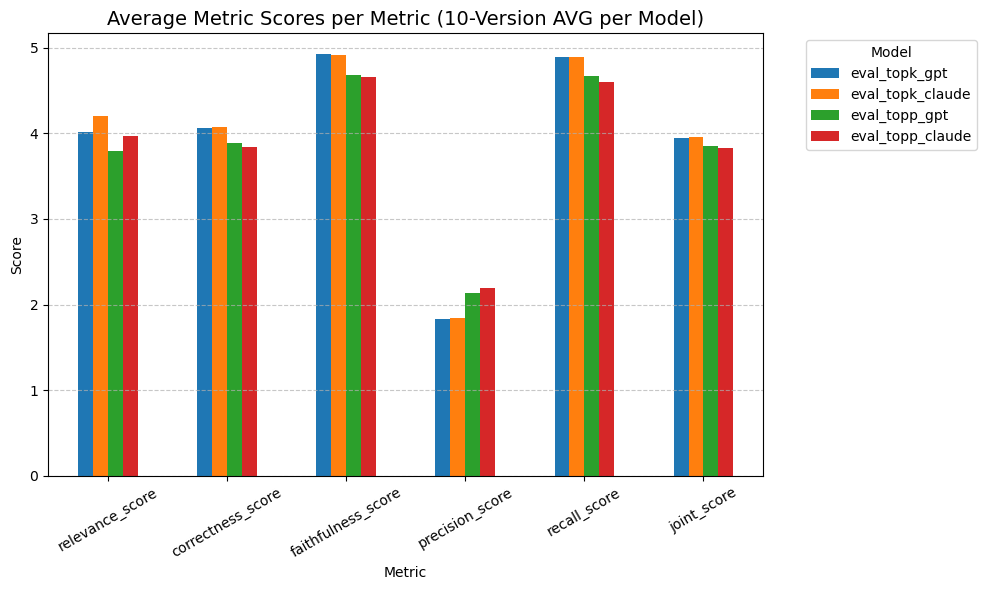

In [31]:
# Transpose the DataFrame so that metrics are on x-axis and models as bars
avg_score_df_T = avg_score_df.T  # shape: (model, metric)
avg_score_df_plot = avg_score_df_T.T  # shape: (metric, model)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

avg_score_df_plot.plot(kind="bar", ax=ax)

ax.set_title("Average Metric Scores per Metric (10-Version AVG per Model)", fontsize=14)
ax.set_ylabel("Score")
ax.set_xlabel("Metric")
ax.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
ax.grid(True, axis="y", linestyle="--", alpha=0.7)
ax.tick_params(axis="x", labelrotation=30)
plt.tight_layout()
plt.show()


In [19]:
# Module 3: Compute metric std across 10 versions per model

model_std_devs = {}
model_metric_distribution = {model: {metric: [] for metric in metric_cols} for model in eval_models}

for model in eval_models:
    for version in versions:
        path = os.path.join(output_dir, f"{model}_{version}.csv")
        if os.path.exists(path):
            df = pd.read_csv(path)
            df_avg = df[df["respondent_id"] == "AVG"]
            if not df_avg.empty:
                for metric in metric_cols:
                    model_metric_distribution[model][metric].append(df_avg[metric].values[0])
    
    # Compute std dev per metric
    stds = {metric: pd.Series(values).std() for metric, values in model_metric_distribution[model].items()}
    model_std_devs[model] = stds

# Tabular output of standard deviation per metric
std_df = pd.DataFrame(model_std_devs).T[metric_cols]
std_df


,relevance_score,correctness_score,faithfulness_score,precision_score,recall_score,joint_score
eval_topk_gpt,0.042373,0.040916,0.028764,0.025021,0.030107,0.032905
eval_topk_claude,0.023768,0.019800,0.021460,0.019629,0.022727,0.007122
eval_topp_gpt,0.040705,0.028183,0.041446,0.023636,0.034224,0.027861
eval_topp_claude,0.041214,0.040329,0.039782,0.025838,0.039666,0.031145


<Figure size 1200x600 with 0 Axes>

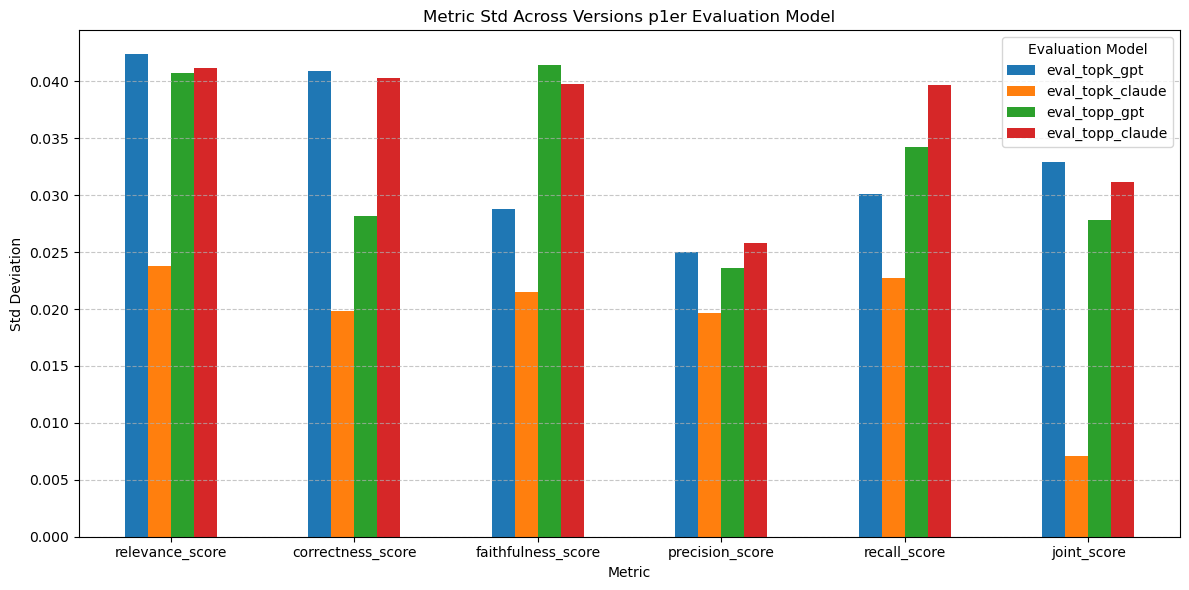

In [20]:
# Module 4: Visualize metric std per model

plt.figure(figsize=(12, 6))
std_df.T.plot(kind="bar", figsize=(12, 6))
plt.title("Metric Std Across Versions p1er Evaluation Model")
plt.ylabel("Std Deviation")
plt.xlabel("Metric")
plt.xticks(rotation=0)
plt.legend(title="Evaluation Model")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


/var/folders/zb/534tsy351nb06sq12xhx2x0w0000gn/T/ipykernel_89722/46921151.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(data, labels=eval_models, patch_artist=True)
/var/folders/zb/534tsy351nb06sq12xhx2x0w0000gn/T/ipykernel_89722/46921151.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(data, labels=eval_models, patch_artist=True)
/var/folders/zb/534tsy351nb06sq12xhx2x0w0000gn/T/ipykernel_89722/46921151.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(data, labels=eval_models, patch_artist=True)
/var/folders/zb/534tsy351nb06sq12xhx2x0w0000gn/T/ipykernel_89722

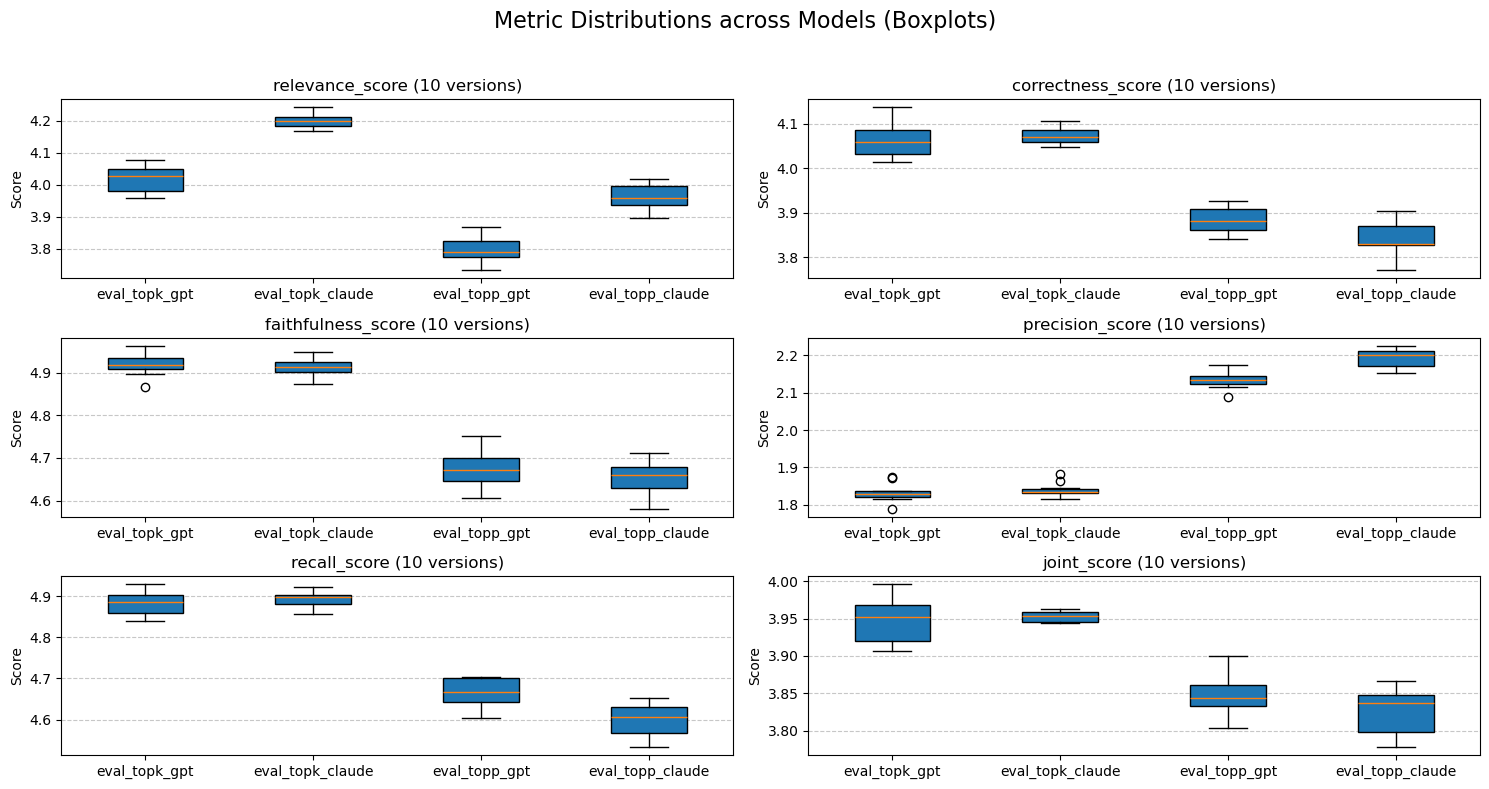

In [26]:
# Plot boxplots for each metric across 4 models in separate subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 8))  # 2 rows × 3 columns layout
axes = axes.flatten()

for i, metric in enumerate(metric_cols):
    data = [model_metric_distribution[model][metric] for model in eval_models]

    axes[i].boxplot(data, labels=eval_models, patch_artist=True)
    axes[i].set_title(f"{metric} (10 versions)")
    axes[i].set_ylabel("Score")
    axes[i].grid(True, axis="y", linestyle="--", alpha=0.7)

# Hide the last empty subplot if metric count < subplots
if len(metric_cols) < len(axes):
    for j in range(len(metric_cols), len(axes)):
        fig.delaxes(axes[j])

fig.suptitle("Metric Distributions across Models (Boxplots)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
